In [1]:
import os, sys, re, functools, itertools, collections, time, random, pickle, warnings, json
pkg_path = '/home/jupyter/code'
if pkg_path not in sys.path:
    sys.path.append(pkg_path)
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from utility import get_label_image, get_cor, get_cor_map, get_topk_indices, get_cor_map_4d, get_local_mean
from utility import get_prime_factors
from visualization import imshow, plot_image_label_overlay, make_video_ffmpeg, get_good_colors, plot_colortable
from models import UNet
from denoise import get_denoised_mat, model_denoise, SeparateNet
from segmentation import get_traces

use_gpu = True
if use_gpu and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Load data

In [2]:
mat = torch.from_numpy(np.load('../data/mat.npy')).float().to(device)
nframe, nrow, ncol = mat.shape

# Noise2Self

In [3]:
save_folder = '2d-noise2self-weighted'
use_weighted_loss = True
use_importance_sampling = True
use_existing_config = True
use_pretrained_model = True
ndim = 2
out_channels =  [64, 64, 128] #[64, 64, 64] #[32, 32, 32]
frame_depth = 4
kernel_size = 3
last_out_channels = [100]
separate_net = False
batch_size = 5
batch_size_eval = 10

num_epochs = 40
num_iters = 800
mask_prob = 0.05
loss_threshold = 0
loss_reg_fn = nn.MSELoss()
if use_weighted_loss:
    weight = mat - mat.min()
    weight = weight*mat.numel()/weight.sum()
    weight = weight.mean(0)
    def loss_fn_reg(pred, target, weight=weight, loss_fn=loss_reg_fn):
        return loss_fn(pred*weight, target*weight)    
optimizer_fn_args = {'lr': 1e-3, 'weight_decay': 1e-2}  
lr_scheduler = {'lr_fn': lambda epoch, num_epochs, lr0, log_fold_change: lr0 * np.exp(-log_fold_change/max(num_epochs-1, 1)*epoch), 
                'lr_fn_args': {'lr0': optimizer_fn_args['lr'], 'num_epochs': num_epochs, 'log_fold_change': np.log(10)}}
optimizer_fn = torch.optim.AdamW
movie_start_idx = 100
movie_end_idx = 700

if separate_net:
    num_features = 32
    temporal_out_channels=[32, 32, 32, 1]
    num_conv_temporal = len(temporal_out_channels)
    assert temporal_out_channels[-1] == 1
    assert (2*frame_depth) % num_conv_temporal == 0

if use_existing_config and os.path.exists(f'{save_folder}/config.json'):
    with open(f'{save_folder}/config.json', 'r') as f:
        config = json.load(f)
        print('Use existing config.json:\n', json.dumps(config, indent=2))
        ndim = config['default_config']['model_config']['ndim']
        out_channels = config['default_config']['model_config']['out_channels']
        frame_depth = config['default_config']['model_config']['frame_depth']
        kernel_size = config['default_config']['model_config']['kernel_size']
        last_out_channels = config['default_config']['model_config']['last_out_channels']
        separate_net = config['default_config']['model_config']['separate_net']
        if separate_net:
            num_features = config['default_config']['model_config']['num_features']
            temporal_out_channels = config['default_config']['model_config']['temporal_out_channels']
            num_conv_temporal = len(temporal_out_channels)
else:
    config = {'default_config': {'model_config': 
                             {'ndim': ndim, 'out_channels': out_channels, 'frame_depth': frame_depth, 'kernel_size': kernel_size,
                              'last_out_channels': last_out_channels, 'separate_net': separate_net}}}
    if config['default_config']['model_config']['separate_net']:
        config['default_config']['model_config'].update({'num_features': num_features, 'temporal_out_channels': temporal_out_channels})
        
print_every = max(num_iters // 2, 1)
assert kernel_size%2==1
encoder_depth = len(out_channels)
padding = (kernel_size-1)//2
pool_kernel_size_row = get_prime_factors(nrow)[:encoder_depth]
pool_kernel_size_col = get_prime_factors(ncol)[:encoder_depth]

if ndim == 2:
    if separate_net:
        k = 2*frame_depth//num_conv_temporal + 1
        model = SeparateNet(in_channels=1, num_features=num_features, spatial_out_channels=out_channels,
                 num_conv=2, kernel_size=kernel_size, padding=padding, 
                 pool_kernel_size=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in range(encoder_depth)],  
                 transpose_kernel_size=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))],
                 transpose_stride=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))], 
                 last_out_channels=last_out_channels, 
                 use_adaptive_pooling=False, padding_mode='replicate', 
                 temporal_out_channels=temporal_out_channels, temporal_kernel_size=(k, 1, 1),
                 normalization='layer_norm', activation=nn.LeakyReLU(negative_slope=0.01, inplace=True)).to(device)
    else:
        in_channels = frame_depth*2 + 1
        model = UNet(in_channels=in_channels, num_classes=1, out_channels=out_channels, num_conv=2, n_dim=2, 
                     kernel_size=kernel_size, 
                     padding=padding, 
                     pool_kernel_size=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in range(encoder_depth)], 
                     transpose_kernel_size=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))], 
                     transpose_stride=[(pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))], 
                     last_out_channels=last_out_channels, 
                     use_adaptive_pooling=False, same_shape=True, padding_mode='replicate', normalization='layer_norm',
                     activation=nn.LeakyReLU(negative_slope=0.01, inplace=True)).to(device)
elif ndim == 3:
    assert frame_depth % encoder_depth == 0
    k = frame_depth//encoder_depth + 1
    model = UNet(in_channels=1, num_classes=1, out_channels=out_channels, num_conv=2, n_dim=3, 
             kernel_size=[kernel_size] + [(k, kernel_size, kernel_size)]*encoder_depth + [(1, kernel_size, kernel_size)]*encoder_depth, 
                 padding=[padding] + [(0, padding, padding)]*encoder_depth*2,
                 pool_kernel_size=[(1, pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in range(encoder_depth)], 
                 transpose_kernel_size=[(1, pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))], 
                 transpose_stride=[(1, pool_kernel_size_row[i], pool_kernel_size_col[i]) for i in reversed(range(encoder_depth))], 
                 last_out_channels=last_out_channels,
                 use_adaptive_pooling=True, same_shape=False, padding_mode='zeros', normalization='layer_norm', 
                 activation=nn.LeakyReLU(negative_slope=0.01, inplace=True)).to(device)
cnt = 0
for n, p in model.named_parameters():
    cnt += p.numel()
print(f'Total number of model parameters = {cnt}')
config['default_config']['model_config'].update({'num_total_params': cnt})

if not os.path.exists(save_folder):
    print(f'Creating folder {save_folder}')
    os.makedirs(save_folder)

loss_history = []
if use_pretrained_model and os.path.exists(f'{save_folder}/loss__denoise.npy'):
    loss_history = np.load(f'{save_folder}/loss__denoise.npy').tolist()
    print(f'loading model state {save_folder}/model_step{len(loss_history)}.pt')
    model.load_state_dict(torch.load(f'{save_folder}/model_step{len(loss_history)}.pt'))
    plt.figure(figsize=(15, 9))
    plt.plot(loss_history, 'o-', markersize=3)
    plt.ylabel('loss')
    plt.xlabel(f'iteration')
    plt.title(f'loss_history[{len(loss_history)}] = ({loss_history[-1]:.3e})')
    plt.show()
    
if use_importance_sampling:
    frame_mean = mat.mean((1, 2))
    frame_weight = frame_mean - frame_mean.min()
    frame_weight = frame_weight + frame_weight.median()
    frame_weight /= frame_weight.sum()
    frame_weight = frame_weight.cpu().numpy()
else:
    frame_weight = None

Total number of model parameters = 1178963
Creating folder 2d-noise2self-weighted


Epoch 1 set learning rate to be 1.00e-03
i=1, loss=1.9960650205612183
i=400, loss=0.6904775500297546
i=800, loss=0.7041741609573364
Epoch 1 time: 195.85821890830994


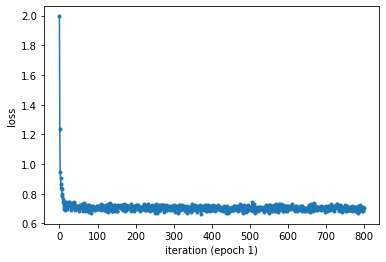

Epoch 2 set learning rate to be 9.43e-04
i=1, loss=0.7113833427429199
i=400, loss=0.6930842399597168
i=800, loss=0.6942183971405029
Epoch 2 time: 195.22907853126526


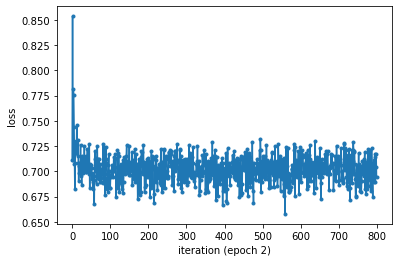

Epoch 3 set learning rate to be 8.89e-04
i=1, loss=0.7027489542961121
i=400, loss=0.6866441369056702
i=800, loss=0.6906053423881531
Epoch 3 time: 195.15636920928955


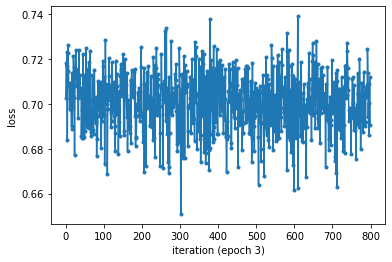

Epoch 4 set learning rate to be 8.38e-04
i=1, loss=0.6936585903167725
i=400, loss=0.7154905796051025
i=800, loss=0.6966513395309448
Epoch 4 time: 195.15927267074585


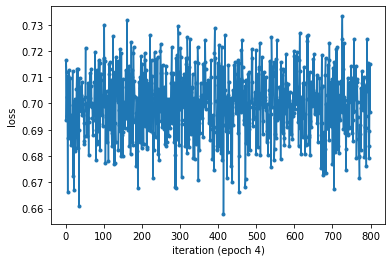

Epoch 5 set learning rate to be 7.90e-04
i=1, loss=0.6910025477409363
i=400, loss=0.6947314739227295
i=800, loss=0.6996517777442932
Epoch 5 time: 195.08449339866638


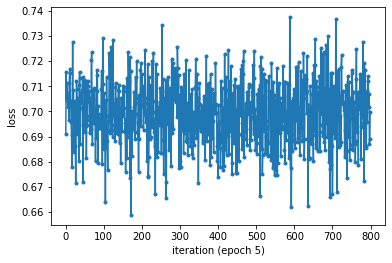

Epoch 6 set learning rate to be 7.44e-04
i=1, loss=0.7147060632705688
i=400, loss=0.7029597163200378
i=800, loss=0.6877334117889404
Epoch 6 time: 195.15003895759583


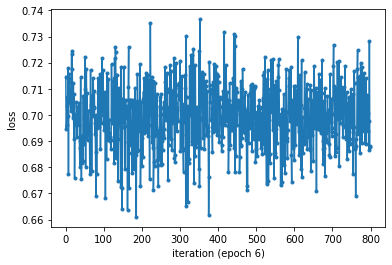

Epoch 7 set learning rate to be 7.02e-04
i=1, loss=0.7096577882766724
i=400, loss=0.7117962837219238
i=800, loss=0.7125927209854126
Epoch 7 time: 195.06503081321716


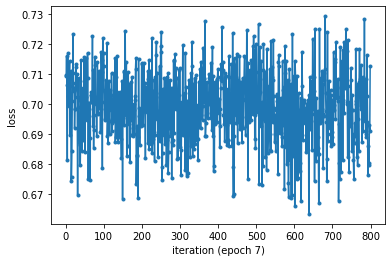

Epoch 8 set learning rate to be 6.61e-04
i=1, loss=0.7047210335731506
i=400, loss=0.6974235773086548
i=800, loss=0.6701005101203918
Epoch 8 time: 195.09145188331604


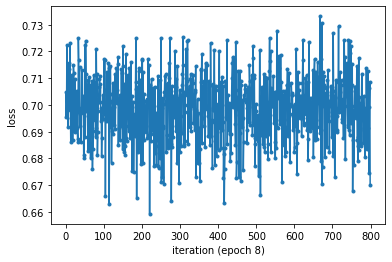

Epoch 9 set learning rate to be 6.24e-04
i=1, loss=0.7086302042007446
i=400, loss=0.6859884262084961
i=800, loss=0.693229615688324
Epoch 9 time: 195.1544167995453


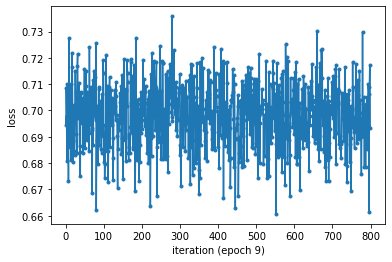

Epoch 10 set learning rate to be 5.88e-04
i=1, loss=0.6898072361946106
i=400, loss=0.6937462091445923
i=800, loss=0.7040889263153076
Epoch 10 time: 195.10834908485413


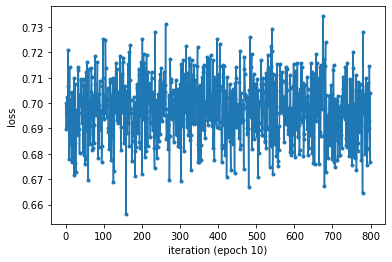

Epoch 11 set learning rate to be 5.54e-04
i=1, loss=0.7034850716590881
i=400, loss=0.7157629132270813
i=800, loss=0.6984882354736328
Epoch 11 time: 195.02853775024414


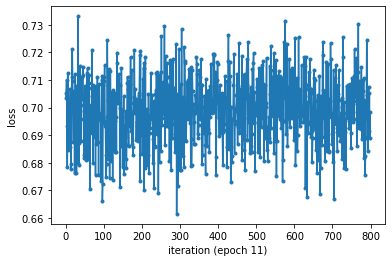

Epoch 12 set learning rate to be 5.22e-04
i=1, loss=0.716835618019104
i=400, loss=0.7064477801322937
i=800, loss=0.6824436783790588
Epoch 12 time: 194.99985575675964


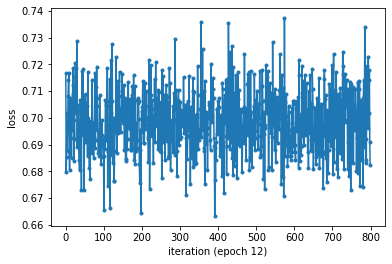

Epoch 13 set learning rate to be 4.92e-04
i=1, loss=0.6971349716186523
i=400, loss=0.689980685710907
i=800, loss=0.7025108337402344
Epoch 13 time: 195.0446479320526


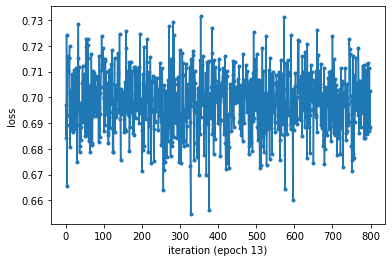

Epoch 14 set learning rate to be 4.64e-04
i=1, loss=0.6989954710006714
i=400, loss=0.7222281694412231
i=800, loss=0.6764657497406006
Epoch 14 time: 195.06955313682556


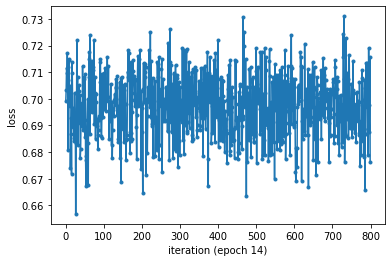

Epoch 15 set learning rate to be 4.38e-04
i=1, loss=0.6911166906356812
i=400, loss=0.7079090476036072
i=800, loss=0.6921067237854004
Epoch 15 time: 195.089537858963


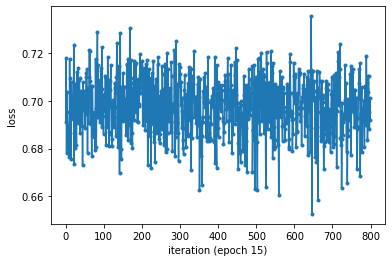

Epoch 16 set learning rate to be 4.12e-04
i=1, loss=0.7115180492401123
i=400, loss=0.7180608510971069
i=800, loss=0.7018623352050781
Epoch 16 time: 195.115553855896


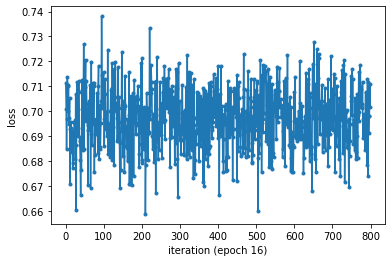

Epoch 17 set learning rate to be 3.89e-04
i=1, loss=0.7052921652793884
i=400, loss=0.6977285146713257
i=800, loss=0.6950746178627014
Epoch 17 time: 195.13850021362305


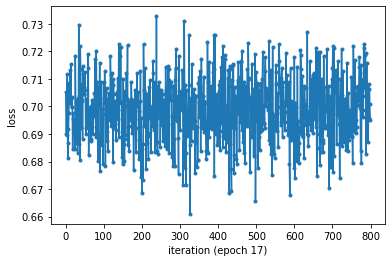

Epoch 18 set learning rate to be 3.67e-04
i=1, loss=0.7042980194091797
i=400, loss=0.693945050239563
i=800, loss=0.7076274156570435
Epoch 18 time: 195.1316521167755


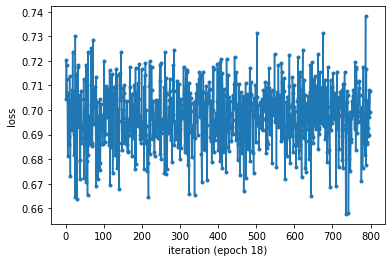

Epoch 19 set learning rate to be 3.46e-04
i=1, loss=0.6865760087966919
i=400, loss=0.7078455686569214
i=800, loss=0.7137912511825562
Epoch 19 time: 195.15173244476318


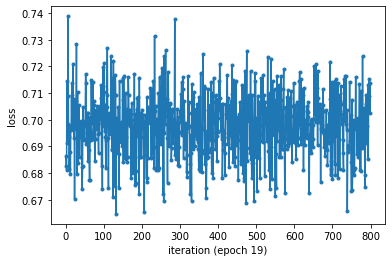

Epoch 20 set learning rate to be 3.26e-04
i=1, loss=0.7089080214500427
i=400, loss=0.7160902619361877
i=800, loss=0.6965713500976562
Epoch 20 time: 195.16357731819153


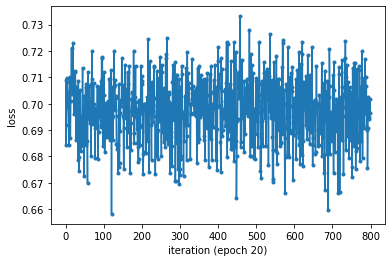

Epoch 21 set learning rate to be 3.07e-04
i=1, loss=0.6976388096809387
i=400, loss=0.7079205513000488
i=800, loss=0.708877682685852
Epoch 21 time: 195.1075201034546


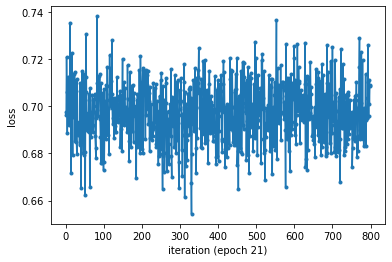

Epoch 22 set learning rate to be 2.89e-04
i=1, loss=0.6893566250801086
i=400, loss=0.6939800977706909
i=800, loss=0.7202515006065369
Epoch 22 time: 195.16575717926025


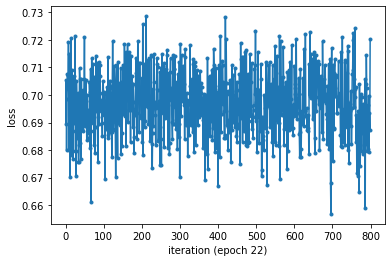

Epoch 23 set learning rate to be 2.73e-04
i=1, loss=0.6930686831474304
i=400, loss=0.698704719543457
i=800, loss=0.7157778143882751
Epoch 23 time: 195.0774986743927


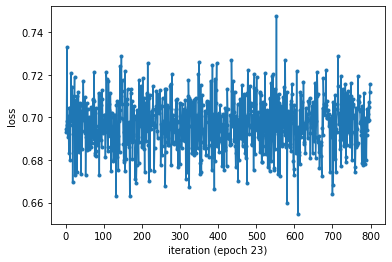

Epoch 24 set learning rate to be 2.57e-04
i=1, loss=0.6987868547439575
i=400, loss=0.6799086928367615
i=800, loss=0.6941572427749634
Epoch 24 time: 195.1643295288086


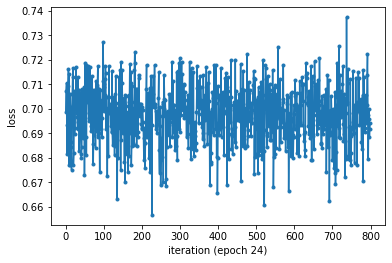

Epoch 25 set learning rate to be 2.42e-04
i=1, loss=0.6906235814094543
i=400, loss=0.704367995262146
i=800, loss=0.7140205502510071
Epoch 25 time: 195.16442680358887


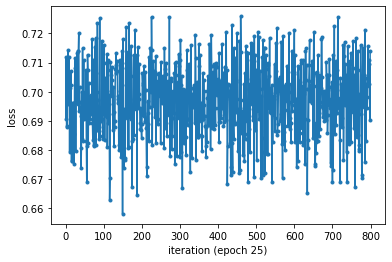

Epoch 26 set learning rate to be 2.29e-04
i=1, loss=0.6887357234954834
i=400, loss=0.7055635452270508
i=800, loss=0.7018641829490662
Epoch 26 time: 195.129700422287


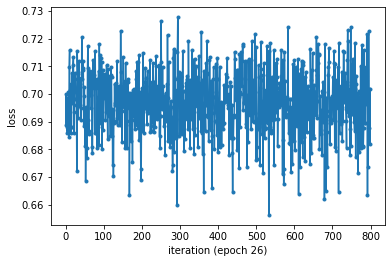

Epoch 27 set learning rate to be 2.15e-04
i=1, loss=0.6891402006149292
i=400, loss=0.7074330449104309
i=800, loss=0.7004478573799133
Epoch 27 time: 195.18914103507996


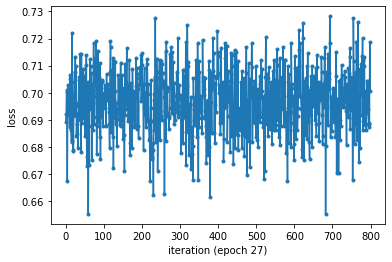

Epoch 28 set learning rate to be 2.03e-04
i=1, loss=0.7024990916252136
i=400, loss=0.7108514904975891
i=800, loss=0.6913923025131226
Epoch 28 time: 195.16386795043945


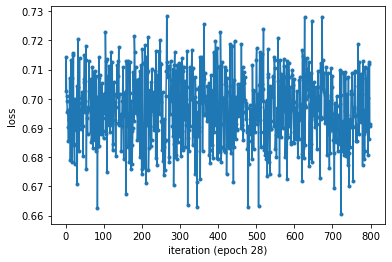

Epoch 29 set learning rate to be 1.91e-04
i=1, loss=0.6894720196723938
i=400, loss=0.7016874551773071
i=800, loss=0.6956418752670288
Epoch 29 time: 195.06676959991455


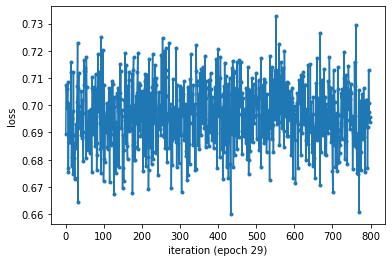

Epoch 30 set learning rate to be 1.80e-04
i=1, loss=0.6730902791023254
i=400, loss=0.7065173387527466
i=800, loss=0.7087733745574951
Epoch 30 time: 195.11490178108215


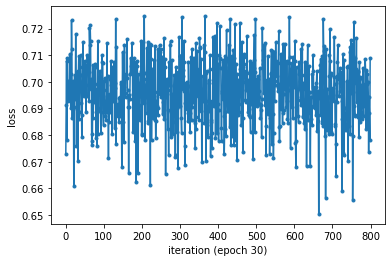

Epoch 31 set learning rate to be 1.70e-04
i=1, loss=0.7126073241233826
i=400, loss=0.666085958480835
i=800, loss=0.6959942579269409
Epoch 31 time: 195.16196012496948


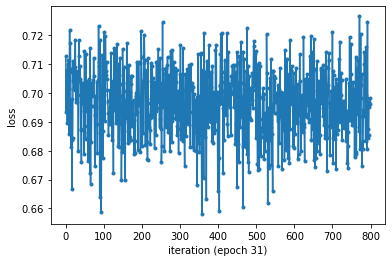

Epoch 32 set learning rate to be 1.60e-04
i=1, loss=0.6988257765769958
i=400, loss=0.706786036491394
i=800, loss=0.6997711062431335
Epoch 32 time: 195.11035466194153


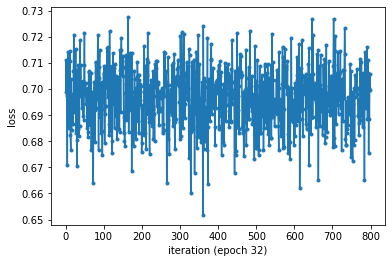

Epoch 33 set learning rate to be 1.51e-04
i=1, loss=0.7112752199172974
i=400, loss=0.6753374934196472
i=800, loss=0.6829949617385864
Epoch 33 time: 195.17322373390198


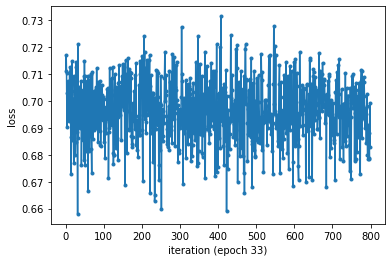

Epoch 34 set learning rate to be 1.43e-04
i=1, loss=0.69296795129776
i=400, loss=0.7028051018714905
i=800, loss=0.6917911171913147
Epoch 34 time: 195.1936571598053


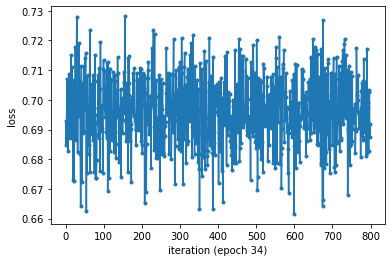

Epoch 35 set learning rate to be 1.34e-04
i=1, loss=0.7016477584838867
i=400, loss=0.6805195212364197
i=800, loss=0.700758159160614
Epoch 35 time: 195.10526490211487


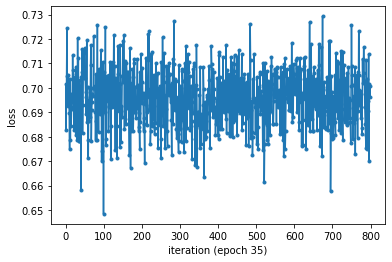

Epoch 36 set learning rate to be 1.27e-04
i=1, loss=0.7031136155128479
i=400, loss=0.7147802114486694
i=800, loss=0.6805443167686462
Epoch 36 time: 195.20742106437683


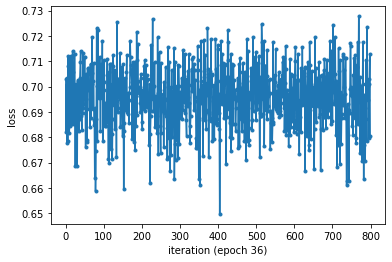

Epoch 37 set learning rate to be 1.19e-04
i=1, loss=0.6946134567260742
i=400, loss=0.7028324604034424
i=800, loss=0.702327311038971
Epoch 37 time: 195.1520812511444


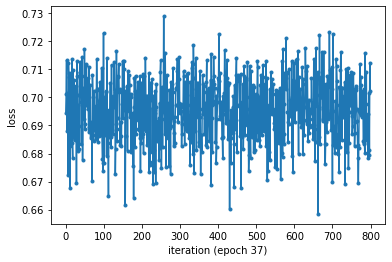

Epoch 38 set learning rate to be 1.13e-04
i=1, loss=0.6568207144737244
i=400, loss=0.6687391400337219
i=800, loss=0.6840085983276367
Epoch 38 time: 195.11356377601624


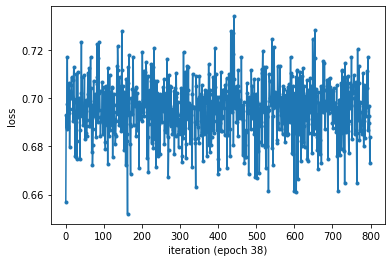

Epoch 39 set learning rate to be 1.06e-04
i=1, loss=0.7204867005348206
i=400, loss=0.713995099067688
i=800, loss=0.6870449781417847
Epoch 39 time: 195.16178727149963


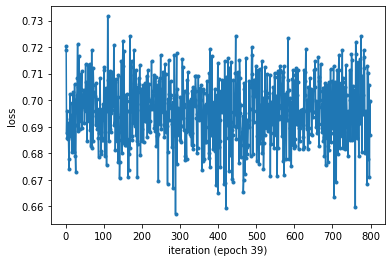

Epoch 40 set learning rate to be 1.00e-04
i=1, loss=0.7113447785377502
i=400, loss=0.6746494770050049
i=800, loss=0.6984545588493347
Epoch 40 time: 195.1934106349945


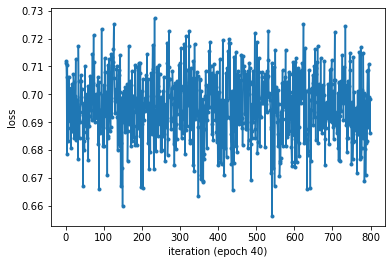

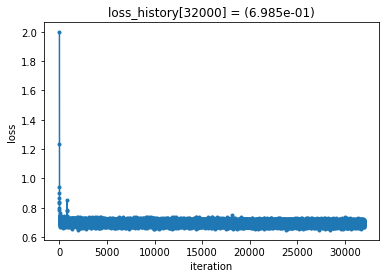

Total time spent: 8205.159341335297


In [4]:
train_interval = [0, mat.shape[0]]
train_index = range(*train_interval)
start_time = time.time()
denoised_mat, model = get_denoised_mat(mat[train_index], model=model, ndim=ndim, out_channels=out_channels, 
                                       num_epochs=num_epochs, num_iters=num_iters, 
                                       print_every=print_every, batch_size=batch_size, mask_prob=mask_prob, 
                                       frame_depth=frame_depth, frame_weight=frame_weight, 
                                       movie_start_idx=movie_start_idx, movie_end_idx=movie_end_idx, 
                                       save_folder=save_folder, 
                                       save_intermediate_results=True, normalize=True, 
                                       last_out_channels=last_out_channels, 
                                       loss_reg_fn=loss_reg_fn, loss_history=loss_history, loss_threshold=loss_threshold, 
                                       optimizer_fn=optimizer_fn, optimizer_fn_args=optimizer_fn_args, lr_scheduler=lr_scheduler,
                                       batch_size_eval=batch_size_eval, 
                                       verbose=True, return_model=True, device=device)
end_time = time.time()

num_episodes = len([k for k in config.keys() if re.search('^episode', k)])
config[f'episode{num_episodes}'] = {'train_settings': 
                                   {'num_epochs': num_epochs, 'num_iters': num_iters, 'batch_size': batch_size, 
                                    'batch_size_eval': batch_size_eval, 'mask_prob': mask_prob,
                                    'use_importance_sampling': use_importance_sampling, 'time_spent': end_time-start_time,
                                    'optimizer_fn_args': optimizer_fn_args, 'train_interval': train_interval
                                   }}
if lr_scheduler is not None:
    config[f'episode{num_episodes}']['train_settings']['lr_scheduler'] = (
        [lr_scheduler['lr_fn'](epoch, **lr_scheduler['lr_fn_args']) for epoch in range(num_epochs)])
with open(f'{save_folder}/config.json', 'w') as f:
    json.dump(config, f, indent=2)

In [5]:
if mat[train_index].shape[0] < mat.shape[0]:
    start_time = time.time()
    denoised_mat = model_denoise(mat, model, ndim=ndim, frame_depth=frame_depth, normalize=True, batch_size=batch_size_eval)
    end_time = time.time()
    np.save(f'{save_folder}/denoised_movie_full_step{len(loss_history)}.npy', denoised_mat.cpu().numpy())
    print(end_time - start_time)